# Apply Data Augmentation to model 2
The goal of this code is to improve false positiveness in model 2 object detection. This failed to improve. I consider to change color of training images for next trial.

## Setup

In [0]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

import numpy as np
from matplotlib.pyplot import imread, imshow, subplots, show
import matplotlib.pyplot as plt
import math
from google.colab import files
import pickle

## Hyperparameter

In [0]:
label_name = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
FROG_IDX = int(np.where(label_name == 'frog')[0])
NUM_IMAGES = 10
NUM_SHOW = 20
NUM_CLASSES = 10
BATCH_SIZE = 50
EPOCHS = 200
model_path_1 = "C:/Users/yukic/OneDrive/git/object_detection/models/model_2.h5"
filename = 'model_2_aug.h5'
LEARNING_RATE = 0.0001
SAVE_FIG_ACC = 'model_2_aug_acc.png'
SAVE_FIG_LOSS = 'model_2_aug_loss.png'

## Data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_test.shape)
print("The number of frog images:", np.sum(y_train == FROG_IDX))

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
The number of frog images: 5000


## Frog images

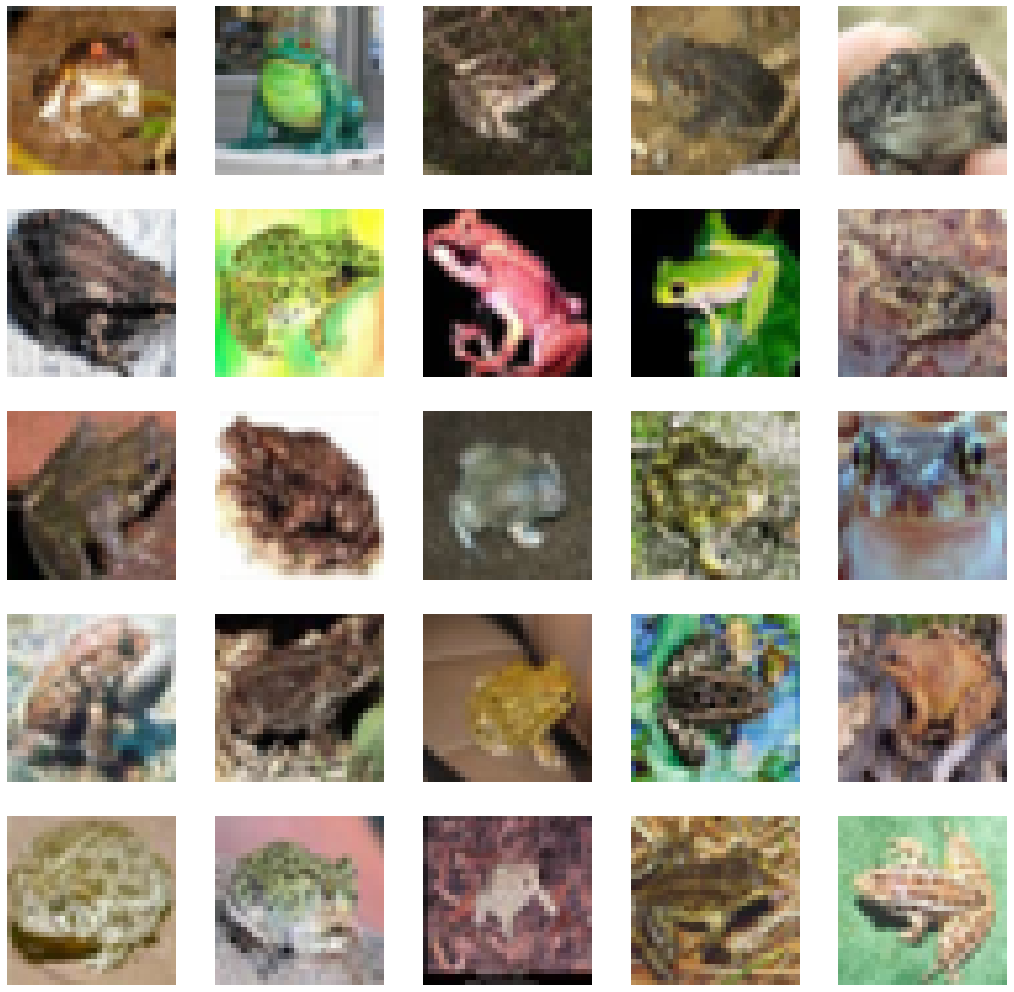

In [4]:
FROG_IDXS = np.where(y_train == FROG_IDX)[0]
x_train_frog = x_train[FROG_IDXS]

plt.figure(figsize = (18, 18))

num = 0
for i in range(25):
    num += 1
    plt.subplot(5, 5, num)
    plt.imshow(x_train_frog[i])
    plt.axis('off')

plt.show()

## Data augmentation

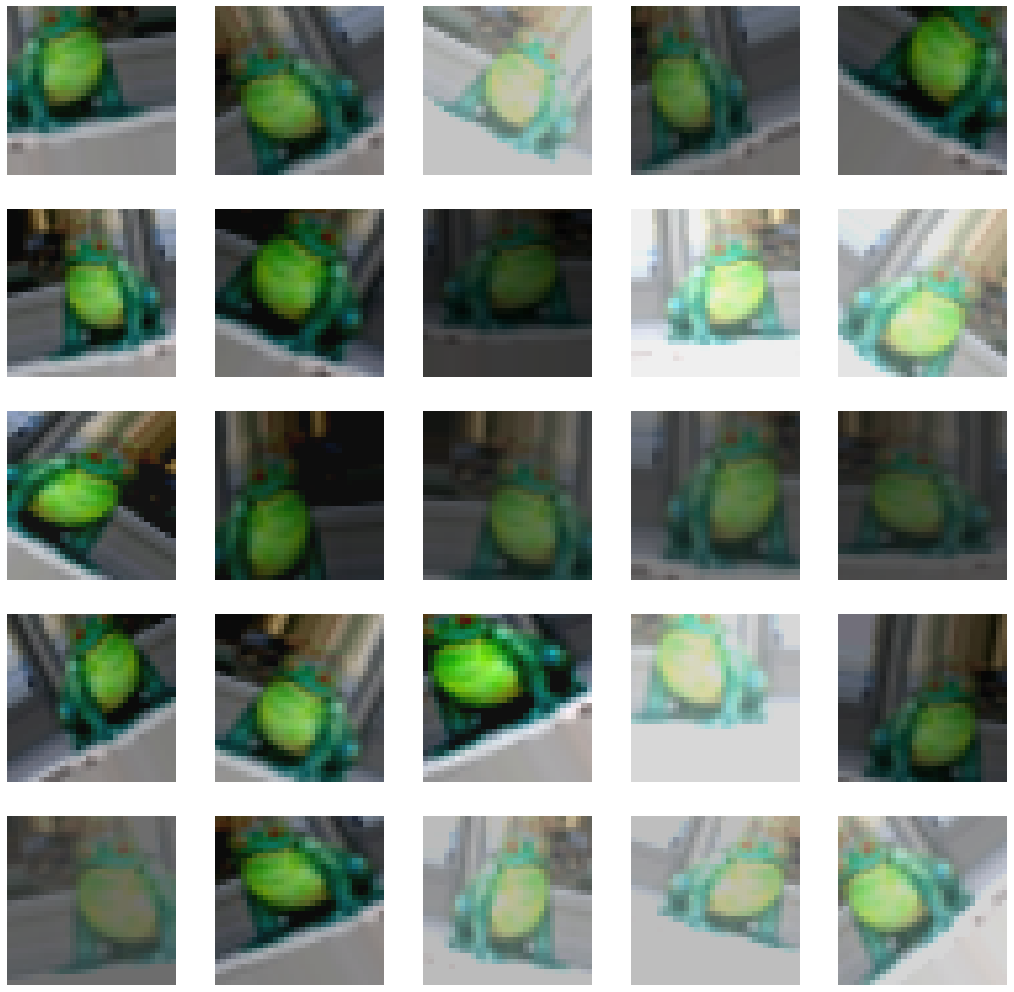

In [5]:
x = x_train_frog[1]
x = x.reshape((1,) + x.shape)

datagen = ImageDataGenerator(# rescale = 1./255,
                             channel_shift_range = 100.0,
                             brightness_range = (0.3, 0.99),
                             rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True)

datagen.fit(x)
image_iterator = datagen.flow(x)

plt.figure(figsize = (18, 18))

for i in range(1, 26, 1):
    plt.subplot(5, 5, i)
    plt.imshow(image_iterator.next()[0].astype('int'))
    plt.axis('off')

plt.show()

## Preprocess

In [0]:
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

## Generator

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   channel_shift_range = 100.0,
                                   brightness_range = (0.3, 0.99),
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size = BATCH_SIZE)
validation_generator = test_datagen.flow(x_test, y_test, batch_size = BATCH_SIZE)

## Model

In [8]:
# build model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# compile model
opt = Adam(lr=LEARNING_RATE)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# summary
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________

## Training

In [9]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = math.ceil(len(x_train)/BATCH_SIZE),
                              epochs = EPOCHS,
                              validation_data = validation_generator,
                              validation_steps = math.ceil(len(x_test)/BATCH_SIZE),
                              verbose = 2)

Epoch 1/200
Epoch 1/200
1000/1000 - 47s - loss: 2.1409 - acc: 0.2129 - val_loss: 1.7811 - val_acc: 0.3591
Epoch 2/200
Epoch 1/200
1000/1000 - 41s - loss: 1.9317 - acc: 0.2901 - val_loss: 1.5769 - val_acc: 0.4252
Epoch 3/200
Epoch 1/200
1000/1000 - 41s - loss: 1.8286 - acc: 0.3331 - val_loss: 1.5616 - val_acc: 0.4151
Epoch 4/200
Epoch 1/200
1000/1000 - 41s - loss: 1.7576 - acc: 0.3603 - val_loss: 1.4868 - val_acc: 0.4528
Epoch 5/200
Epoch 1/200
1000/1000 - 41s - loss: 1.7036 - acc: 0.3791 - val_loss: 1.3574 - val_acc: 0.5104
Epoch 6/200
Epoch 1/200
1000/1000 - 41s - loss: 1.6629 - acc: 0.3950 - val_loss: 1.3474 - val_acc: 0.5106
Epoch 7/200
Epoch 1/200
1000/1000 - 41s - loss: 1.6156 - acc: 0.4126 - val_loss: 1.3058 - val_acc: 0.5341
Epoch 8/200
Epoch 1/200
1000/1000 - 41s - loss: 1.5892 - acc: 0.4217 - val_loss: 1.2824 - val_acc: 0.5316
Epoch 9/200
Epoch 1/200
1000/1000 - 41s - loss: 1.5459 - acc: 0.4416 - val_loss: 1.3394 - val_acc: 0.5115
Epoch 10/200
Epoch 1/200
1000/1000 - 41s - los

## Evaluation

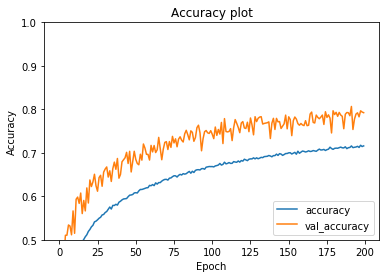

In [18]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig(SAVE_FIG_ACC)
plt.show()

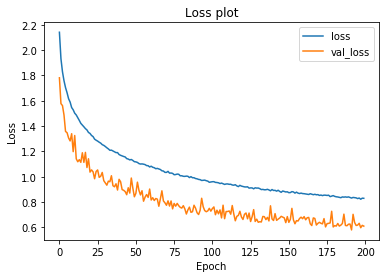

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.legend(loc='upper right')
plt.savefig(SAVE_FIG_LOSS)
plt.show()

In [0]:
files.download(SAVE_FIG_ACC)

In [0]:
files.download(SAVE_FIG_LOSS)

## Save weights

In [0]:
model.save(filename)

## Download weights

In [0]:
files.download(filename)